In [80]:
import numpy as np
import scipy

from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation
#from scipy.linalg import expm


import pulser
import qutip
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.waveforms import RampWaveform, ConstantWaveform
from pulser.devices import Chadoq2, MockDevice

from pasqal_cloud import SDK
from pasqal_cloud.device import EmulatorType

In [81]:
Omega = 1   * 2*np.pi
delta = 0.7 * 2*np.pi
U = 138e5

In [82]:
def MOF_reader(mol_str):
   with open('dataset_txt/'+mol_str+'_txt') as file:
    lines = file.readlines()
    N = len(lines)-1
    d = float(lines[0])
    plane_coords = np.array([lines[i].split() for i in range(1,N+1)], float)
    
    return d, plane_coords

In [83]:
d,coords = MOF_reader("PIYZAZ")
coords

array([[-1.14781586, -2.51657527],
       [-1.20399955, -3.05947659],
       [-1.31627547, -4.14441774],
       [-0.97936604, -0.88873178],
       [-1.26015127, -3.60208425],
       [-1.09163536, -1.97367359],
       [-1.03548229, -1.43106611],
       [-0.60530961, -2.57271694],
       [-1.69032225, -2.46043488]])

129.98694572404085


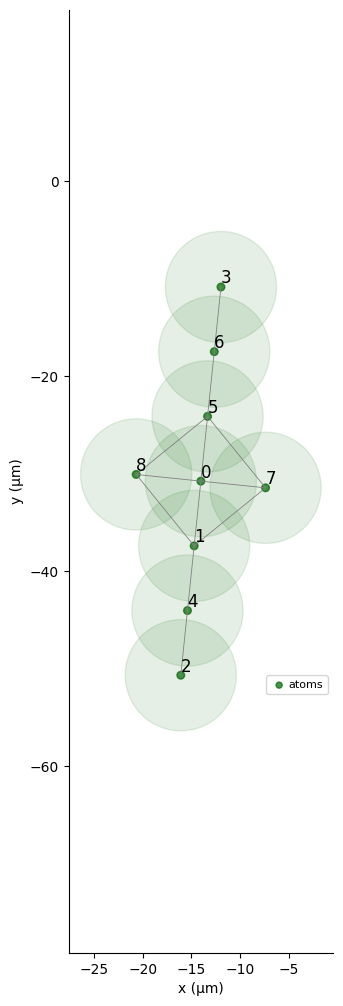

In [84]:
print((U/Omega)**(1/3))
n = 6
w = np.exp(1j*2*np.pi/(n))

n = len(coords)
def graph_desc(rNN):
    #G1 = [[rNN/(2*np.sin(np.pi/(3)))*(1+w**i).real,rNN/(2*np.sin(np.pi/(3)))*(w**i).imag] for i in range(3)] \
    #    + [[rNN/(2*np.sin(np.pi/(3)))*(-1.+w**1).real,rNN/(2*np.sin(np.pi/(3)))*(.5j+w**1).imag]] \
    #    + [[rNN/(2*np.sin(np.pi/(3)))*(-.8+w**2).real,rNN/(2*np.sin(np.pi/(3)))*(-.5j+w**2).imag]] \
    #    + [[rNN/(2*np.sin(np.pi/(3)))*(-3+w**2).real,rNN/(2*np.sin(np.pi/(3)))*(-.3j+w**2).imag]]
    
    #G1 = [[rNN/(2*np.sin(np.pi/(3)))*(1+w**i).real,rNN/(2*np.sin(np.pi/(3)))*(w**i).imag] for i in range(3)]
    #G1+= [[rNN/(2*np.sin(np.pi/(3)))*(-1+w**2).real,rNN/(2*np.sin(np.pi/(3)))*(w**2).imag],\
    #    [rNN/(2*np.sin(np.pi/(3)))*(-2.5+w**2).real,rNN/(2*np.sin(np.pi/(3)))*(w**2).imag] ]
    #G1 = [[rNN*i, 0] for i in range(n)]
    G1 = [rNN*np.array([c[0],c[1]]) for c in coords/3/d]
    #G1 = [[rNN/(2*np.sin(np.pi/(4)))*(w**i).real,rNN/(2*np.sin(np.pi/(4)))*(w**i).imag] for i in range(n)]
    return G1

#rNN = 11
#G1 = [[rNN/(2*np.sin(np.pi/(n)))*(w**i).real,rNN/(2*np.sin(np.pi/(n)))*(w**i).imag] for i in range(n)]
G1 = graph_desc(11)

Rij1 = np.zeros((n,n))
for i in range(n):
    for j in range(i):
        Rij1[i,j] = np.linalg.norm(np.array(G1[i])-np.array(G1[j]))
        Rij1[j,i] = Rij1[i,j]
        
def excitation(j, total_sites):
    """The |0><0| projector operator on site j."""
    prod = [qutip.qeye(2) for _ in range(total_sites)]
    prod[j] = (qutip.qeye(2) + qutip.sigmaz()) / 2
    return qutip.tensor(prod)



def excitation2():
    """The |0><0| projector operator on site j."""
    prod = [qutip.qeye(2) for _ in range(n)]
    for j in range(n):
        prod[j] = (qutip.qeye(2) + qutip.sigmaz()) / 2
    return qutip.tensor(prod)


#excited = excitation2()
excited = excitation(0, len(coords))

qubits1 = dict(enumerate(G1))
reg1 = Register(qubits1)
reg1.draw(blockade_radius=(U/Omega)**(1/6), draw_half_radius=True, draw_graph=True)

In [85]:
seq = Sequence(reg1, MockDevice)
seq.declare_channel("ising", "rydberg_global")


M = 15000
sampling_rate = 1/75

simple_pulse = Pulse.ConstantPulse(M, Omega, delta, 0)

seq.add(simple_pulse, "ising")
seq.measure(basis="ground-rydberg")

sim = QutipEmulator.from_sequence(seq,sampling_rate=sampling_rate)

results = sim.run(progress_bar=True, nsteps=5000)

10.0%. Run time:   0.08s. Est. time left: 00:00:00:00
20.0%. Run time:   0.18s. Est. time left: 00:00:00:00
30.0%. Run time:   0.28s. Est. time left: 00:00:00:00
40.0%. Run time:   0.38s. Est. time left: 00:00:00:00
50.0%. Run time:   0.49s. Est. time left: 00:00:00:00
60.0%. Run time:   0.60s. Est. time left: 00:00:00:00
70.0%. Run time:   0.68s. Est. time left: 00:00:00:00
80.0%. Run time:   0.77s. Est. time left: 00:00:00:00
90.0%. Run time:   0.87s. Est. time left: 00:00:00:00
Total run time:   0.96s


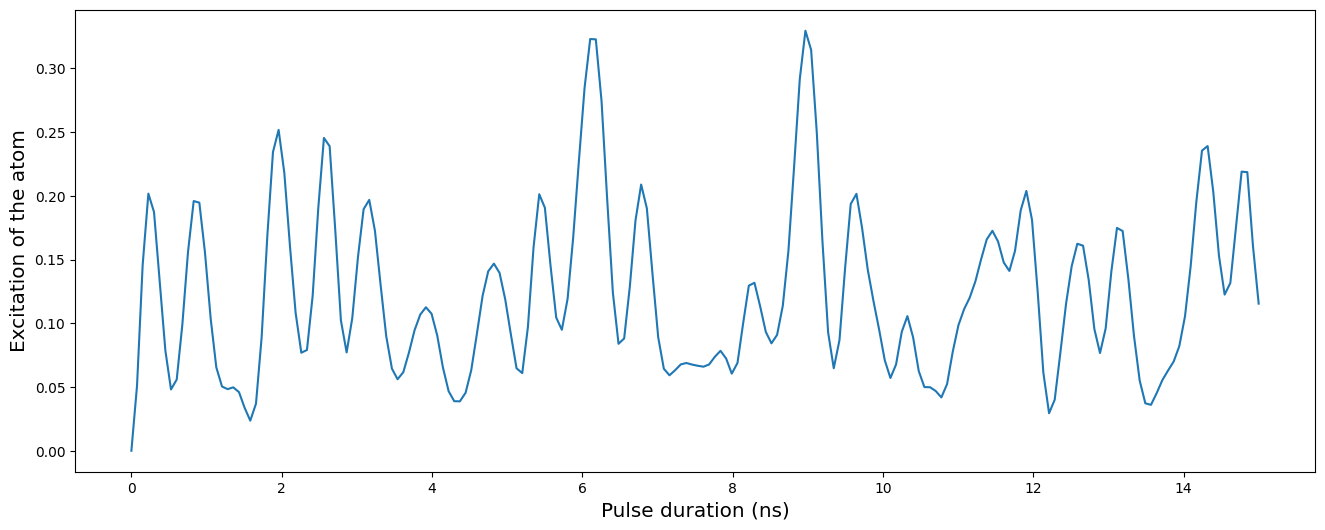

In [86]:

plt.figure(figsize=[16, 6])
results.plot(excited)
plt.xlabel("Pulse duration (ns)", fontsize="x-large")
plt.ylabel("Excitation of the atom", fontsize="x-large")
plt.show()

In [87]:
#print(results.expect([excited]))
arr = results.expect([excited])[0]

[ 0.          0.07537688  0.15075377  0.22613065  0.30150754  0.37688442
  0.45226131  0.52763819  0.60301508  0.67839196  0.75376884  0.82914573
  0.90452261  0.9798995   1.05527638  1.13065327  1.20603015  1.28140704
  1.35678392  1.4321608   1.50753769  1.58291457  1.65829146  1.73366834
  1.80904523  1.88442211  1.95979899  2.03517588  2.11055276  2.18592965
  2.26130653  2.33668342  2.4120603   2.48743719  2.56281407  2.63819095
  2.71356784  2.78894472  2.86432161  2.93969849  3.01507538  3.09045226
  3.16582915  3.24120603  3.31658291  3.3919598   3.46733668  3.54271357
  3.61809045  3.69346734  3.76884422  3.84422111  3.91959799  3.99497487
  4.07035176  4.14572864  4.22110553  4.29648241  4.3718593   4.44723618
  4.52261307  4.59798995  4.67336683  4.74874372  4.8241206   4.89949749
  4.97487437  5.05025126  5.12562814  5.20100503  5.27638191  5.35175879
  5.42713568  5.50251256  5.57788945  5.65326633  5.72864322  5.8040201
  5.87939698  5.95477387  6.03015075  6.10552764  6.

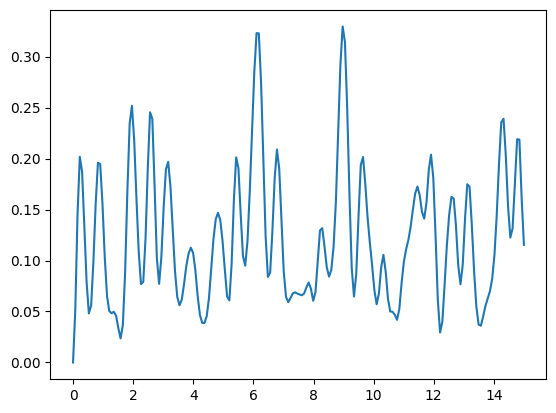

In [88]:

T = np.linspace(0,M/1000,int(sampling_rate*M))
print(T)
plt.plot(T,arr)

In [89]:
K = 100
rNN_vec = np.linspace(25,5.,K)
#print(rNN_vec[91])

In [90]:
rNN_vec[5]

23.98989898989899

5.0


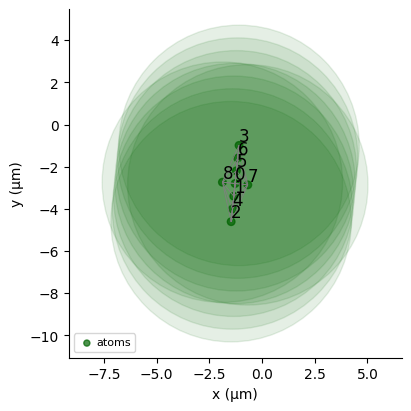

In [91]:
G1 = graph_desc(1.)
print(rNN_vec[-1])
qubits1 = dict(enumerate(G1))
reg1 = Register(qubits1)
reg1.draw(blockade_radius=(U/Omega)**(1/6), draw_half_radius=True, draw_graph=True)

In [92]:

results = []
for k in range(K):
    if(k%10==0):
        print(k)
    rNN = rNN_vec[k]
    #G1 = [[rNN/(2*np.sin(np.pi/(n)))*(w**i).real,rNN/(2*np.sin(np.pi/(n)))*(w**i).imag] for i in range(n)]
    G1 = graph_desc(rNN_vec[k])
    #G1 = [[rNN/(2*np.sin(np.pi/(3)))*(1+w**i).real,rNN/(2*np.sin(np.pi/(3)))*(w**i).imag] for i in range(3)] \
    #        + [[rNN/(2*np.sin(np.pi/(3)))*(-1.+w**1).real,rNN/(2*np.sin(np.pi/(3)))*(.5j+w**1).imag]] \
    #        + [[rNN/(2*np.sin(np.pi/(3)))*(-.8+w**2).real,rNN/(2*np.sin(np.pi/(3)))*(-.5j+w**2).imag]] \
    #        + [[rNN/(2*np.sin(np.pi/(3)))*(-3+w**2).real,rNN/(2*np.sin(np.pi/(3)))*(-.3j+w**2).imag]]
    
    #Rij1 = np.zeros((n,n))
    #for i in range(n):
    #    for j in range(i):
    #        Rij1[i,j] = np.linalg.norm(np.array(G1[i])-np.array(G1[j]))
    #        Rij1[j,i] = Rij1[i,j]

    qubits1 = dict(enumerate(G1))
    reg1 = Register(qubits1)

    seq = Sequence(reg1, MockDevice)
    seq.declare_channel("ising", "rydberg_global")

    simple_pulse = Pulse.ConstantPulse(M, Omega, 3*Omega, 0)

    #_omega = ConstantWaveform(M, Omega)
    #_omega = RampWaveform(M, rNN_vec[24], rNN_vec[0])
    #_delta = RampWaveform(M, 24, 4)  # Duration: 1000ns, linear sweep from -20 to 20 rad/µs
    #_delta = ConstantWaveform(M, 3*Omega)
    
    #simple_pulse = Pulse(_omega,_delta,phase=0)
    
    seq.add(simple_pulse, "ising")
    seq.measure(basis="ground-rydberg")

    sim = QutipEmulator.from_sequence(seq,sampling_rate=sampling_rate)

    result = sim.run(progress_bar=False, nsteps=50000)

    results.append(result.expect([excited])[0])

0


10
20
30
40
50
60
70
80
90


In [93]:
results = np.array(results)

#T = np.linspace(0,4,int(M*sampling_rate))

fig, ax = plt.subplots()
l, = plt.plot(T,results[0,:])
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_ylim([0,2])

def animate(i):
    l.set_data(T,results[i,:])
    ax.set_title(rNN_vec[i])
ani = matplotlib.animation.FuncAnimation(fig, animate, interval=25, frames=K)

       
HTML(ani.to_jshtml())

In [94]:
#print(dt)
#print((scipy.fft.fftfreq(M*10, dt/10)))
#print(results)
#print(1/dt)
#print(scipy.fft.fftfreq(M, dt))
int(M*sampling_rate)

200

In [95]:
# For better frequency resolution



FFT = np.zeros((K,int(M*sampling_rate//2)))
FFTw = np.zeros((K,int(M*sampling_rate//2)))
dt = T[1]-T[0]
xf = scipy.fft.fftfreq(int(M*sampling_rate), dt)[:int(M*sampling_rate//2)]

from scipy.signal.windows import blackman
#window = blackman(T.shape[-1]//samplinsg_rate+1)

for i in range(K):
    results_sampled = results[i,:]

    FFT[i,:] = 2/M/sampling_rate*np.abs(scipy.fft.fft(results_sampled)[:int(M*sampling_rate//2)])
    #FFTw[i,:] = 2/M*np.abs(scipy.fft.fft(results_sampled*window)[:M//sampling_rate//2])
    


In [96]:
print(len(xf))
print(xf)


100
[0.         0.06633333 0.13266667 0.199      0.26533333 0.33166667
 0.398      0.46433333 0.53066667 0.597      0.66333333 0.72966667
 0.796      0.86233333 0.92866667 0.995      1.06133333 1.12766667
 1.194      1.26033333 1.32666667 1.393      1.45933333 1.52566667
 1.592      1.65833333 1.72466667 1.791      1.85733333 1.92366667
 1.99       2.05633333 2.12266667 2.189      2.25533333 2.32166667
 2.388      2.45433333 2.52066667 2.587      2.65333333 2.71966667
 2.786      2.85233333 2.91866667 2.985      3.05133333 3.11766667
 3.184      3.25033333 3.31666667 3.383      3.44933333 3.51566667
 3.582      3.64833333 3.71466667 3.781      3.84733333 3.91366667
 3.98       4.04633333 4.11266667 4.179      4.24533333 4.31166667
 4.378      4.44433333 4.51066667 4.577      4.64333333 4.70966667
 4.776      4.84233333 4.90866667 4.975      5.04133333 5.10766667
 5.174      5.24033333 5.30666667 5.373      5.43933333 5.50566667
 5.572      5.63833333 5.70466667 5.771      5.83733333 5.

In [97]:
fig, ax = plt.subplots()
l, = plt.plot(xf,FFT[0,:])
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_ylim([0,0.75])
ax.set_xlim([0,5])

def animate(i):
    l.set_data(xf,FFT[i,:])
    ax.set_title(rNN_vec[i])
ani = matplotlib.animation.FuncAnimation(fig, animate, interval=100, frames=K)

       
HTML(ani.to_jshtml())

# ani.save('FFT_rNN_hexa.gif')

In [98]:
np.log(FFT[0,:])

array([-2.22344458, -5.64656738, -6.27716326, -6.59338575, -6.75391887,
       -6.87863696, -6.92338685, -6.94949927, -6.98870945, -6.99687113,
       -6.99438746, -7.01016081, -7.00732079, -6.99302031, -6.99857303,
       -6.99097224, -6.96812637, -6.9680791 , -6.95882319, -6.92539773,
       -6.92394606, -6.92483971, -6.84427913, -6.83882165, -6.8033095 ,
       -6.79538984, -6.76979196, -6.72521855, -6.77064117, -6.68394633,
       -6.63469773, -6.60427658, -6.55232304, -6.49581149, -6.4472859 ,
       -6.38421097, -6.31175555, -6.24110283, -6.15572422, -6.05527597,
       -5.94817813, -5.81911803, -5.66099755, -5.47380776, -5.22966495,
       -4.88362438, -4.34069937, -3.5516898 , -3.52749645, -4.54851131,
       -5.05911136, -5.3997548 , -5.66265651, -5.87895606, -6.05435689,
       -6.21302682, -6.35472915, -6.47538469, -6.59021659, -6.69907278,
       -6.79109466, -6.8816614 , -6.97210804, -7.04580313, -7.12007309,
       -7.20001176, -7.25966024, -7.3210022 , -7.39836473, -7.44

In [99]:
print(Omega/2/np.pi*np.sqrt(n))

3.0


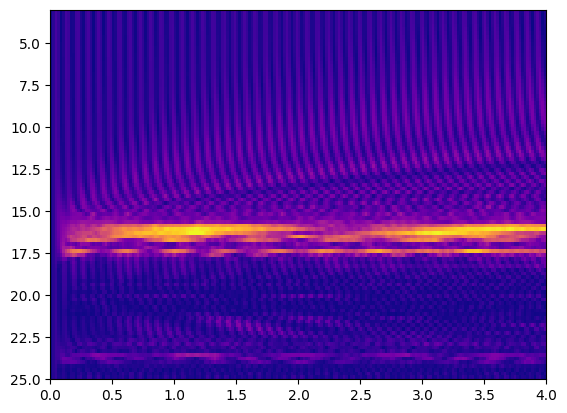

In [100]:

plt.imshow(results, cmap='plasma', interpolation='nearest',extent=(0,4,25,3), aspect='auto')
plt.show()

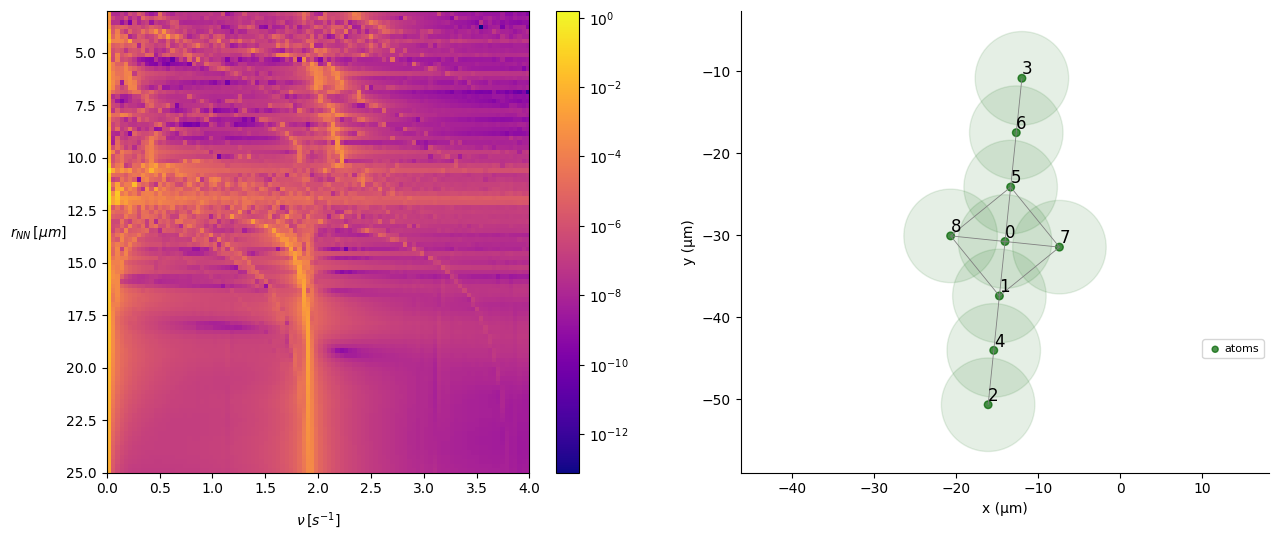

In [101]:
#fftbis = np.array([FFT[i,:],rNN_vec[i] for i in range(100)])
#print(fftbis.shape)
#fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,6))
plt.rcParams['text.usetex'] = False
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
ax1.set_ylabel(r'$r_{NN}\, [\mu m]$',rotation=0,labelpad=20)#, loc='top')
ax1.set_xlabel(r'$\nu\,[s^{-1}]$',rotation=0,labelpad=10)#, loc='right')
im = ax1.imshow(np.log(FFT[:,:]),cmap='plasma',origin='lower', interpolation='nearest', extent=(0,4,25,3), aspect='auto')
#ax2.imshow(np.log(FFTw),cmap='plasma',origin='lower', interpolation='nearest', extent=(0,4,25,0.5))
#ax1.setgrid()
ax1.set_title("")

import matplotlib.ticker as ticker
def fmt(x, pos):
    #a, b = '{:.2e}'.format(x).split('e')
    #b = int(b)
    return r'$10^{{{}}}$'.format(int(x))

plt.colorbar(im, format=ticker.FuncFormatter(fmt))
#fig.colorbar(im)
#ax1.grid(alpha=0.5, linestyle='-', linewidth=1)
G1 = graph_desc(11)

qubits1 = dict(enumerate(G1))
reg1 = Register(qubits1)
reg1.draw(blockade_radius=(U/Omega)**(1/6), draw_half_radius=True, draw_graph=True,custom_ax=ax2)


plt.show()